In [1]:
from flask import Flask, jsonify, render_template
import psycopg2
from psycopg2.extras import RealDictCursor
import geopandas as gpd
import folium
import pandas as pd
from sqlalchemy import create_engine
#from shapely import wkt
from shapely import wkb
from config import db_name, user, password, host

app = Flask(__name__)
app.config['DEBUG'] = True

def get_db_connection():
    try:
        conn = psycopg2.connect(
            dbname=db_name,
            user=user,
            password=password,
            host=host
        )
        return conn
    except psycopg2.Error as e:
        app.logger.error(f"Error connecting to database: {e}")
        return None


In [144]:
#conn = get_db_connection()
from shapely.geometry import Polygon, MultiPolygon  # Import Polygon and MultiPolygon
# Create a SQLAlchemy engine
engine = create_engine(f'postgresql://{user}:{password}@{host}/{db_name}')

# Function to convert memoryview to bytes
def memoryview_to_bytes(mv):
    return mv.tobytes()

# SQL query to retrieve the geometries as text
sql = """
SELECT
    cod_reg,
    cod_rip,
    cod_prov,
    ar_kmq,
    nome,
    uid,
    ar_fr_p3p4,
    ar_fr_p2,
    ar_fr_p1,
    pop_fr_p2,
    pop_fr_p1,
    ed_fr_p2,
    ed_fr_p1,
    ar_frp3p4p,
    popfrp3p4p,
    ed_fr_p3p4,
    edfrp3p4p,
    ST_AsBinary(ST_SnapToGrid(geometry, 0.001)) as geom_wkb  -- Adjust 0.001 for your desired precision
FROM dataset
"""
#ST_AsBinary(geometry) as geom_wkb 
# Step 1: Read the data from the database
df = pd.read_sql(sql, engine)

In [145]:
# Step 2: Convert the WKB geometries to Shapely geometries
df['geom_wkb'] = df['geom_wkb'].apply(memoryview_to_bytes)
df['geometry'] = df['geom_wkb'].apply(wkb.loads)

#print (df)

In [146]:
# Drop the WKB geometry column as it's no longer needed
df = df.drop(columns='geom_wkb' )
geometry = df.pop('geometry')

df1 = pd.DataFrame()

gdf1 = gpd.GeoDataFrame(geometry)


<Axes: >

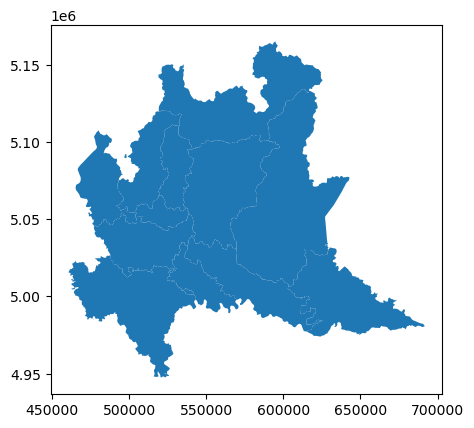

In [147]:
gdf1.plot()

In [148]:
#geometry = gdf1.pop('geometry')

In [149]:
print(geometry)

0     POLYGON ((483071.565 5104606.091, 483258.471 5...
1     MULTIPOLYGON (((498077.206 5089780.201, 497614...
2     POLYGON ((595652.3640000001 5163515.664, 59604...
3     MULTIPOLYGON (((538136.2930000001 5004372.82, ...
4     POLYGON ((585288.233 5104483.086, 585414.67 51...
5     POLYGON ((615296.0260000001 5132340.8780000005...
6     MULTIPOLYGON (((485536.498 4985444.636, 485366...
7     POLYGON ((542189.5430000001 5037362.593, 54240...
8     POLYGON ((632564.649 5031233.652, 632845.881 5...
9     POLYGON ((532079.6190000001 5104664.093, 53328...
10    POLYGON ((534551.982 5035118.62, 534818.294 50...
11    POLYGON ((519223.708 5065484.377, 519733.94800...
Name: geometry, dtype: object


In [150]:
#print(df)

In [151]:
#print(geometry)

In [152]:
merged_gdf = gdf1.merge(df, left_index=True, right_index=True)

In [153]:
merged_gdf.geometry

0     POLYGON ((483071.565 5104606.091, 483258.471 5...
1     MULTIPOLYGON (((498077.206 5089780.201, 497614...
2     POLYGON ((595652.364 5163515.664, 596042.425 5...
3     MULTIPOLYGON (((538136.293 5004372.820, 539201...
4     POLYGON ((585288.233 5104483.086, 585414.670 5...
5     POLYGON ((615296.026 5132340.878, 615374.026 5...
6     MULTIPOLYGON (((485536.498 4985444.636, 485366...
7     POLYGON ((542189.543 5037362.593, 542408.354 5...
8     POLYGON ((632564.649 5031233.652, 632845.881 5...
9     POLYGON ((532079.619 5104664.093, 533286.609 5...
10    POLYGON ((534551.982 5035118.620, 534818.294 5...
11    POLYGON ((519223.708 5065484.377, 519733.948 5...
Name: geometry, dtype: geometry

<Axes: >

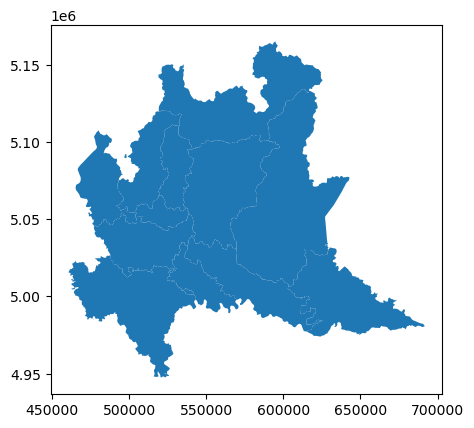

In [154]:
merged_gdf.plot()

In [155]:
# # # Step 2: Convert the text geometries to Shapely geometries
# # df['geometry'] = df['geom'].apply(wkt.loads)
# # df = df.drop(columns='geom')  # Drop the text geometry column
# # Step 3: Convert the DataFrame to a GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry='geometry')
crs_epsg = 'EPSG:32632'
# # Step 4: Set the correct CRS (Coordinate Reference System)
merged_gdf = merged_gdf.set_crs(crs_epsg)  # Replace 4326 with your actual SRID

In [156]:
print(merged_gdf.crs)

EPSG:32632


In [157]:
# Check the GeoDataFrame

print(merged_gdf.crs)

# Close the SQLAlchemy engine
engine.dispose()

EPSG:32632


<Axes: >

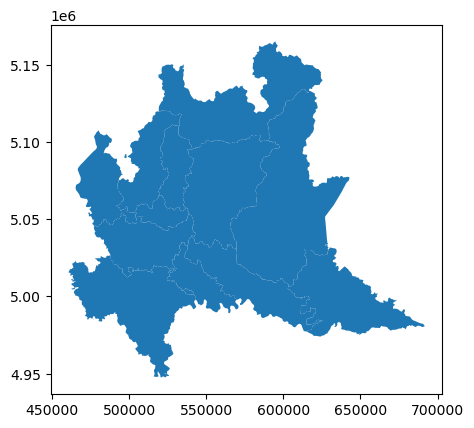

In [158]:
merged_gdf.plot()

In [10]:
gdf.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf.plot()

In [3]:
null_geometries = gdf[gdf['geometry'].isnull()]
print(f"Number of NULL geometries: {len(null_geometries)}")

Number of NULL geometries: 0


In [4]:
from shapely.validation import explain_validity

invalid_geometries = gdf[~gdf['geometry'].is_valid]
print(f"Number of invalid geometries: {len(invalid_geometries)}")

# Optionally, you can print the reason for invalidity
for index, row in invalid_geometries.iterrows():
    print(f"UID: {row['uid']}, Reason: {explain_validity(row['geometry'])}")


Number of invalid geometries: 0


In [ ]:
import numpy as np

def has_nan_coordinates(geom):
    if geom.is_empty:
        return False
    coords = np.array(geom.coords)
    return np.isnan(coords).any()

gdf['has_nan'] = gdf['geometry'].apply(has_nan_coordinates)
nan_coords_geometries = gdf[gdf['has_nan']]
print(f"Number of geometries with NaN coordinates: {len(nan_coords_geometries)}")


In [9]:
import numpy as np
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString, MultiLineString

def has_nan_coordinates(geom):
    if geom.is_empty:
        return False
    
    # Check for single geometries
    if isinstance(geom, (Point, LineString, Polygon)):
        coords = np.array(geom.coords)
        return np.isnan(coords).any()
    
    # Check for multi-part geometries
    elif isinstance(geom, MultiPoint):
        for point in geom.geoms:
            coords = np.array(point.coords)
            if np.isnan(coords).any():
                return True
        return False
    
    elif isinstance(geom, MultiLineString):
        for linestring in geom.geoms:
            coords = np.array(linestring.coords)
            if np.isnan(coords).any():
                return True
        return False
    
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            for ring in polygon.exterior.coords:
                coords = np.array(ring)
                if np.isnan(coords).any():
                    return True
            for interior in polygon.interiors:
                for ring in interior.coords:
                    coords = np.array(ring)
                    if np.isnan(coords).any():
                        return True
        return False

    # If geometry type is not recognized
    else:
        raise TypeError(f"Unhandled geometry type: {type(geom)}")

# Example usage with your GeoDataFrame 'gdf'
gdf['has_nan'] = gdf['geometry'].apply(has_nan_coordinates)
nan_coords_geometries = gdf[gdf['has_nan']]
print(f"Number of geometries with NaN coordinates: {len(nan_coords_geometries)}")


Number of geometries with NaN coordinates: 0


In [ ]:
# plot polygons and make a chloropeth map according to an attribute
m = folium.Map(location=[45.46, 9.19], zoom_start=11, tiles='CartoDB positron')

# folium.GeoJson(milan).add_to(m)

folium.Choropleth(
    geo_data= gdf.to_json(),
    data=gdf,
    columns=[gdf.index,'edfrp3p4p'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='edfrp3p4p',
    name='Milano Zones'
).add_to(m)

folium.LayerControl().add_to(m)
m



In [ ]:
#exterior_coords = [(123.4545345, 23444.43324),(44534.445345,452354.4534534),(45546.456545545,45345.664543)()]
exterior_coords = "POLYGON ((483071.5653999997302890 5104606.0911999996751547, 483258.4707000004127622 5104508.0931000001728535, 484448.1494000004604459 5104563.0918000005185604, 484521.1498999996110797 5104575.0930000003427267, 484825.0522999996319413 5104992.0894000008702278, 485016.9588000001385808 5105278.0864000003784895, 485145.9572999998927116 5105224.0872000008821487, 485397.8614999996498227 5105079.0878999996930361, 485722.7660999996587634 5104870.0910000000149012, 486568.4468999998643994 5104003.0968999993056059, 486706.5384999997913837 5103846.0985000003129244, 487065.8492999998852611 5103333.1007000003010035, 487297.8470999998971820 5103159.1019000001251698, 487407.7521999999880791 5103103.1038000006228685, 487528.7511999998241663 5103072.1033999994397163, 487652.7505999999120831 5103045.1028000004589558, 487764.7507999995723367 5102979.1043999996036291, 487855.7489999998360872 5102885.1040000002831221, 487934.6250999998301268 5102796.1045999992638826, 488179.6240999996662140 5102486.1081000007688999, 488559.5279999999329448 5102449.1099999994039536, 488707.4642000002786517 5101734.6151000000536442, 488747.4327999996021390 5100905.1195999998599291, 487954.5307999998331070 5099452.1315000001341105, 487881.5323999999091029 5099484.1313000004738569, 487472.6331000002101064 5099663.1337000001221895, 487191.7602000003680587 5099766.1328999996185303, 486913.7605999996885657 5099318.1361999996006489, 486981.7619000002741814 5099117.1386999990791082, 487095.6359999999403954 5099046.1392000000923872, 487245.6344999996945262 5098919.1395999994128942, 487026.6353000001981854 5098566.1426999997347593, 486839.7621999997645617 5098682.1399000007659197, 486687.7314999997615814 5097763.6465000007301569, 486654.7630000002682209 5097698.1458999998867512, 486612.7629000004380941 5097619.1468000002205372, 486558.7637000000104308 5097544.1476000007241964, 486043.9534999998286366 5096871.1531000006943941, 485441.0533999996259809 5096679.1544000003486872, 484979.4457000000402331 5096466.6555000003427267, 484302.3428999995812774 5095399.6633999999612570, 483900.4688999997451901 5094622.1684000007808208, 483738.4742999998852611 5094048.1773000005632639, 483418.6441999999806285 5092849.5733000002801418, 483716.3771000001579523 5092769.1815000008791685, 483723.0186000000685453 5092771.4423999991267920, 483810.3755000000819564 5092801.1811999995261431, 483899.3439999995753169 5092851.1808000002056360, 483928.3435000004246831 5092888.1817000005394220, 483918.3760000001639128 5092973.1812999993562698, 483922.3756999997422099 5093056.1799999997019768, 483926.3153999997302890 5093116.7982000000774860, 483927.3839999996125698 5093133.1916000004857779, 483957.3848999999463558 5093165.1914000008255243, 484021.3517000004649162 5093182.1896999999880791, 484074.3514000000432134 5093189.1896999999880791, 484097.3524000002071261 5093189.1896999999880791, 484173.3202999997884035 5093184.1905000004917383, 484213.0696999998763204 5093178.1899999994784594, 484326.2884999997913837 5093160.1901999991387129, 484792.1600000001490116 5093080.1918000001460314, 485157.0639000004157424 5093014.1914000008255243, 485262.0619999999180436 5092967.1922999992966652, 486144.7642000000923872 5092679.1815000008791685, 486932.4456000002101064 5092726.1800999995321035, 487378.3492999998852611 5092374.1827000007033348, 488203.1233000000938773 5091288.1906000003218651, 488210.6856000004336238 5091270.6896999999880791, 488263.0915000000968575 5091151.1897999998182058, 488315.0899000000208616 5091076.1905000004917383, 489789.7353999996557832 5089654.7005000002682209, 490172.6408000001683831 5089482.7048000004142523, 490922.5127999996766448 5089227.2084999997168779, 491807.3228000001981854 5089438.2091000005602837, 492032.3206000002101064 5088922.2131999991834164, 492038.3212999999523163 5088835.2147000003606081, 492027.2273000003769994 5088695.2144000008702278, 492103.2259999997913837 5088352.2179000005125999, 492135.2258000001311302 5088206.2191000003367662, 492146.2254999997094274 5088083.2192000001668930, 492150.2252000002190471 5087959.2197999991476536, 492116.2265999997034669 5087821.2225000001490116, 492072.2255999995395541 5087713.2219999991357327, 491994.2260999996215105 5087566.2237999998033047, 491860.2285000002011657 5087292.2259999997913837, 491734.2281999997794628 5086983.2280000001192093, 491684.2594999996945262 5086841.2289000004529953, 491667.2284000003710389 5086715.2306999992579222, 491675.2298999996855855 5086581.2311000004410744, 491709.2285000002011657 5086424.2324999999254942, 491782.2290000002831221 5086274.2318999990820885, 492070.1019000001251698 5085814.2360999993979931, 492111.1097999997437000 5085756.2493999991565943, 492585.6471999995410442 5085335.2632999997586012, 492779.9579999996349216 5084925.7666999995708466, 492830.2708999998867512 5084900.5171000007539988, 492907.9264000002294779 5084891.7679999992251396, 493074.8945000004023314 5084875.7672000005841255, 493179.8925999999046326 5084868.7671000007539988, 494152.8404999999329448 5083589.7597000002861023, 494193.8104999996721745 5083488.7611999996006489, 494217.8108000000938773 5083351.7632999997586012, 494219.8097000000998378 5083243.7628000006079674, 494196.8107000002637506 5083124.7646999992430210, 494158.8410999998450279 5082945.7645999994128942, 494104.8419000003486872 5082813.7659000009298325, 494090.8726000003516674 5082782.2657999992370605, 494080.8381000002846122 5082759.7618000004440546, 493967.8709000004455447 5082377.7652000002563000, 494060.8424000004306436 5082251.7695000004023314, 494124.7125000003725290 5082057.2645999994128942, 494288.7987000001594424 5082021.2594000007957220, 494357.7993999999016523 5082004.2610999997705221, 494420.7994999997317791 5081970.2603999990969896, 494460.7987000001594424 5081889.2605000007897615, 494684.7971000000834465 5081367.2640000004321337, 494735.7960000000894070 5081236.2666999995708466, 494859.7012000000104308 5080697.2697999998927116, 494879.7017999999225140 5080550.2715000007301569, 494963.7044000001624227 5079802.2786999996751547, 494884.7010000003501773 5079612.2780000008642673, 495368.6736000003293157 5079490.7883999999612570, 495476.6741000004112720 5079593.7877999991178513, 495540.6737000001594424 5079635.7857000008225441, 495580.6421999996528029 5079624.7860000003129244, 495766.6401000004261732 5079352.7890000008046627, 495777.6398000000044703 5079293.7886999994516373, 495764.6392000000923872 5079260.7894999999552965, 495709.6405999995768070 5079173.7890000008046627, 495661.6399999996647239 5079120.7912000007927418, 495587.6727999998256564 5079066.7899999991059303, 495422.6727999998256564 5078952.7909999992698431, 495380.7055000001564622 5078928.7926000002771616, 495363.1909999996423721 5078920.5467000007629395, 495329.6950000002980232 5078904.7800999991595745, 495233.4150000000372529 5078874.1493999995291233, 495230.7054000003263354 5078873.2899999991059303, 495153.7052999995648861 5078850.2891000006347895, 495130.7372000003233552 5078843.2910999990999699, 495073.7375999996438622 5078819.2907999996095896, 494971.7377000004053116 5078766.2909999992698431, 494900.2077999999746680 5078723.7912000007927418, 494825.7652000002563000 5078643.2857000008225441, 494757.7659999998286366 5078558.2861000001430511, 494723.7675000000745058 5078514.2872999999672174, 493710.9266999997198582 5077130.2932999990880489, 493507.9590999996289611 5076798.2943999990820885, 493426.9593000002205372 5076663.2952999994158745, 493200.0009000003337860 5075194.3145000003278255, 492890.0958000002428889 5075127.3146999999880791, 492834.0976999998092651 5075082.3164000008255243, 492807.0970999998971820 5075011.3168000001460314, 492793.0970000000670552 5074951.3169999998062849, 492800.0970999998971820 5074880.3175000008195639, 492820.0976999998092651 5074809.3179000001400709, 492880.0975000001490116 5074773.3184999991208315, 492942.0960999997332692 5074744.3190000001341105, 492988.0959999999031425 5074659.3193999994546175, 493000.0950999995693564 5074531.3202999997884035, 492957.0955999996513128 5074135.3219000007957220, 492775.1542999995872378 5073538.4996000006794930, 491994.2273000003769994 5073267.3291999995708466, 492256.1906000003218651 5072741.8277000002563000, 492278.1593000004068017 5072655.8286000005900860, 492291.1578999999910593 5072542.8289999999105930, 492323.1577000003308058 5072204.8315999992191792, 492323.1577000003308058 5072093.8329000007361174, 492322.1582000004127622 5071962.8335999995470047, 492339.1585999997332692 5071847.8351000007241964, 492365.1577000003308058 5071750.8363000005483627, 492421.1578999999910593 5071549.8368999995291233, 492446.1575999995693564 5071488.8377000000327826, 492615.1245999997481704 5071246.8395000007003546, 492900.5144999995827675 5071084.0743000004440546, 492258.2211999995633960 5070139.3473000004887581, 492341.2192000001668930 5070065.3466999996453524, 492421.2176000000908971 5069978.3463000003248453, 492483.2183999996632338 5069897.3464999999850988, 492687.2160999998450279 5069519.3497999999672174, 492775.0924000004306436 5069305.3532999996095896, 492807.0921000000089407 5069220.3537000007927418, 492802.0930000003427267 5069159.3544999994337559, 492697.2176999999210238 5068325.3597999997437000, 493373.0548999998718500 5068337.8581000007688999, 493396.0537000000476837 5068180.8596999999135733, 493467.0532999997958541 5068042.8603000007569790, 493667.0204999996349216 5067765.8621999993920326, 493815.9890000000596046 5067603.8624000009149313, 493938.9889000002294779 5067439.3641999997198582, 493949.7943000001832843 5067211.5892999991774559, 493949.9880999997258186 5067102.3655999992042780, 493940.9872000003233552 5066984.3669000007212162, 493913.9857000000774860 5066837.6682999990880489, 494053.9563999995589256 5066824.3684999998658895, 494501.0148999998345971 5066753.2806000001728535, 494553.7021000003442168 5065991.3756000008434057, 495540.5394999999552965 5065714.8767000008374453, 495472.5712000001221895 5065689.3774999994784594, 495424.5706000002101064 5065640.3773999996483326, 495276.5729999998584390 5065105.3823000006377697, 495267.5719999996945262 5065010.3824000004678965, 495289.5727000003680587 5064851.3844000007957220, 495554.4771999996155500 5064637.3860999997705221, 495931.3801999995484948 5064391.3881999999284744, 495992.3793999999761581 5064391.3881999999284744, 496138.3782999999821186 5064238.3893999997526407, 496178.3794999998062849 5064173.3904999997466803, 496199.3794999998062849 5064076.3896999992430210, 496205.3781000003218651 5063985.3915999997407198, 496200.2846999997273088 5063660.3927999995648861, 496153.2856000000610948 5063012.3980999998748302, 496188.2856000000610948 5062725.3995999991893768, 496224.2850000001490116 5062417.4032000005245209, 496223.2856999998912215 5062350.4034000001847744, 496164.2852999996393919 5062033.4059999994933605, 496155.2844000002369285 5061991.4058999996632338, 496034.2852999996393919 5061917.4060999993234873, 495959.2861000001430511 5061884.4068999998271465, 495873.2871000003069639 5061820.4074000008404255, 495810.2869999995455146 5061745.4080999996513128, 495945.0723000001162291 5061454.3250999990850687, 495713.2883000001311302 5061463.4089000001549721, 495699.2882000003010035 5061579.4088000003248453, 495681.2884999997913837 5061700.4078000001609325, 495655.3835000004619360 5061800.4068999998271465, 495510.3842000002041459 5062072.4058999996632338, 495474.3847000002861023 5062126.4050999991595745, 495421.3848000001162291 5062134.4045000001788139, 494661.4841000000014901 5061203.4111000001430511, 494667.4826999995857477 5061093.4116999991238117, 494694.4833000004291534 5060593.4166999999433756, 494702.4521000003442168 5060399.4171999990940094, 494699.4517999999225140 5060372.4186000004410744, 494242.7426000004634261 5059963.1985999997705221, 493505.5115000000223517 5059446.5236000008881092, 492583.8121999995782971 5059094.4276000000536442, 492529.8130000000819564 5059083.4278999995440245, 492385.8130999999120831 5059105.4273000005632639, 492169.9084000000730157 5059115.4276999998837709, 491998.9099000003188848 5059082.4285000003874302, 491858.9116000002250075 5059037.4279999993741512, 491797.9179999995976686 5059010.4333999995142221, 491924.9156999997794628 5058521.4381000008434057, 492106.8482999997213483 5058134.4363000001758337, 492814.1191999996080995 5057920.6111999992281199, 492903.6847000000998378 5057636.4381000008434057, 492926.6836000001057982 5057570.4376999996602535, 493122.6204000003635883 5057474.4384000003337860, 493429.5867999996989965 5057505.4387999996542931, 493837.4901000000536442 5057517.4399999994784594, 493873.4895999999716878 5057462.4393000006675720, 493918.7276999996975064 5057392.8880000002682209, 493977.8958000000566244 5056560.4450000002980232, 494455.8941000001505017 5055556.4570000004023314, 494934.8948999997228384 5055432.4622000008821487, 494796.8926999997347593 5055787.4563999995589256, 494853.8921999996528029 5055828.4570000004023314, 495941.8842000002041459 5056377.4520999994128942, 496557.6575999995693564 5056460.9448000006377697, 497049.6272999998182058 5056682.9504000004380941, 497346.5925000002607703 5056848.9488999992609024, 497374.4289999995380640 5056882.2314999997615814, 497438.5922999996691942 5056958.9482000004500151, 497532.5317999999970198 5057095.8958999998867512, 497630.8672000002115965 5057291.4396000001579523, 497891.8664999995380640 5057793.4354999996721745, 498143.8660000003874302 5058263.4355999995023012, 498269.4504000004380941 5058474.6067999992519617, 498472.8645000001415610 5058459.4360000006854534, 498842.2883999999612570 5057434.1980000007897615, 498849.3623999999836087 5056638.4481000006198883, 498770.2345000002533197 5055523.4526000004261732, 498613.2679000003263354 5055337.4541999995708466, 498307.2712000003084540 5054958.4593000002205372, 498428.7454000003635883 5054798.0451999995857477, 498535.2057999996468425 5054657.4608999993652105, 499375.0378000000491738 5054903.7063999995589256, 499401.6484000002965331 5054886.4998000003397465, 499513.0716000003740191 5054814.4569000005722046, 500430.2538999998942018 5054608.4587999992072582, 500683.8782000001519918 5054555.4634000007063150, 500719.8776000002399087 5054552.4630999993532896, 501416.7763000000268221 5054499.4607999995350838, 501562.7443000003695488 5054585.4597999993711710, 501599.2675999999046326 5054705.7148000001907349, 502194.6467000003904104 5054405.9609999991953373, 502792.2044000001624227 5054328.4410999994724989, 503805.4468000000342727 5054696.9572000000625849, 504211.3799000000581145 5054798.9571000002324581, 504343.3919999999925494 5054773.9564999993890524, 504268.3503999998793006 5054618.9594000000506639, 504550.2861999999731779 5054175.9639999996870756, 504874.2220999998971820 5054176.9634000007063150, 504867.1893999995663762 5053856.9657000005245209, 504809.1937999995425344 5053701.9695999994874001, 504463.7159000001847744 5053674.0134999994188547, 504014.8771999999880791 5053311.0836999993771315, 503992.0466000000014901 5052795.1883000005036592, 504074.7240000003948808 5052269.7982000000774860, 504125.7922999998554587 5052184.0983000006526709, 504115.1123000001534820 5052001.3892999999225140, 504106.3488999996334314 5051747.7463000006973743, 504133.2723000003024936 5051210.9992999993264675, 504250.8438999997451901 5051042.6473999992012978, 504497.3965999996289611 5051034.2086999993771315, 504529.6196999996900558 5050937.5089999996125698, 504531.3619999997317791 5050665.2508000005036592, 504781.8823999995365739 5050462.4955000001937151, 504757.8805999998003244 5050341.4946999996900558, 504729.8497999999672174 5050091.4973000008612871, 504708.8190999999642372 5049626.5001999996602535, 504929.7521000001579523 5049347.4987000003457069, 505011.0230000000447035 5049325.3762999996542931, 505047.0221999995410442 5048797.3621999993920326, 505029.6580999996513128 5048485.5054999999701977, 505002.6885999999940395 5048138.6899999994784594, 504988.6272999998182058 5048085.5102999992668629, 504729.4012000001966953 5047509.0986000001430511, 504504.9944000001996756 5047513.7408000007271767, 503965.4391999999061227 5047451.5760999992489815, 503911.3092000000178814 5047402.4679000005125999, 503865.6491000000387430 5047104.3721999991685152, 503589.0149999996647239 5047089.1720000002533197, 502715.2262000003829598 5047651.1783000007271767, 502101.0226999996230006 5048068.5084000006318092, 502080.0533999996259809 5048331.5065000001341105, 502002.0734000001102686 5048325.5074000004678965, 501910.0559999998658895 5047905.5116000007838011, 501673.0899000000208616 5047708.5138000007718801, 501459.0917999995872378 5047626.5145999994128942, 500869.1889000004157424 5047404.5131000000983477, 500864.1876999996602535 5047443.5129000004380941, 500857.1424000002443790 5047451.5974000003188848, 500843.8684999998658895 5047466.8278999999165535, 500745.2207000004127622 5047580.0139000006020069, 500576.2231000000610948 5047458.0133999995887280, 500569.1084000002592802 5047452.4653999991714954, 500458.2549999998882413 5047366.0138000007718801, 500258.8979000002145767 5047169.0355999991297722, 500251.2872999999672174 5047161.5155999995768070, 500163.2882000003010035 5046736.5189999993890524, 499887.3265000004321337 5047086.0231999997049570, 498715.5810000002384186 5048613.0067999996244907, 498481.7116999998688698 5048433.3209000006318092, 498388.2284000003710389 5048367.0189999993890524, 498303.6198000004515052 5048307.0159000009298325, 498002.6541999997571111 5048112.0171000007539988, 497868.6871999995782971 5048239.0166999995708466, 497740.7188999997451901 5048600.0150000005960464, 497594.8113000001758337 5049098.0075000002980232, 497580.8113000001758337 5049159.0066999997943640, 497617.8101000003516674 5049345.0046999994665384, 497635.8098999997600913 5049414.0032999999821186, 497679.8424000004306436 5049586.0043000001460314, 497725.8421999998390675 5049899.0020000003278255, 497715.8727000001817942 5050092.0000000000000000, 497550.9352000001817942 5050389.9969999995082617, 497446.9664000002667308 5050526.4942000005394220, 498194.8996999999508262 5051117.4925999995321035, 498264.8997999997809529 5051185.4918000008910894, 498300.8991999998688698 5051233.4904999993741512, 498235.9309999998658895 5051328.4903999995440245, 498120.9325999999418855 5051257.4908000007271767, 497977.9955000001937151 5051607.4872999992221594, 497961.4440999999642372 5051605.5791999995708466, 497295.2203999999910593 5052952.4793999996036291, 496928.2543000001460314 5052656.4800000004470348, 496560.2560000000521541 5052392.4825999997556210, 496457.2873999997973442 5052436.4834000002592802, 496416.3195000002160668 5052636.4814999997615814, 496385.3191999997943640 5052795.4809000007808208, 496373.3507000003010035 5052865.4790000002831221, 496405.3504999997094274 5052954.4781999997794628, 496610.3569000000134110 5053326.6927000004798174, 496531.3505999995395541 5053298.4761999994516373, 496454.3810999998822808 5053290.4767000004649162, 496392.3825000002980232 5053293.4770999997854233, 496338.3505999995395541 5053296.4752999991178513, 496208.8830000003799796 5053419.4752999991178513, 496129.8841000003740191 5053540.4743000008165836, 496152.8850999996066093 5053592.4747000001370907, 495955.8853000001981854 5053994.4714999999850988, 495846.8854000000283122 5054145.4694999996572733, 495657.8870999999344349 5054154.4703000001609325, 495426.8887000000104308 5054126.4703000001609325, 495314.1284999996423721 5054346.4440999999642372, 495049.8936000000685453 5054213.4713000003248453, 494800.8919999999925494 5053852.4706999994814396, 494465.8949999995529652 5053542.4733000006526709, 494638.8929000003263354 5052785.4768000002950430, 494732.5262000001966953 5052548.4080999996513128, 495064.5142999999225140 5052221.4814999997615814, 494285.8957000002264977 5051819.4853000007569790, 494222.8976999996230006 5051775.4863000009208918, 494023.8974999999627471 5051379.4860999993979931, 494093.8956000003963709 5051300.4870999995619059, 494036.8960999995470047 5051090.4888000003993511, 493994.0604999996721745 5050999.3365000002086163, 493950.8953999998047948 5050907.4891999997198582, 493431.8989000003784895 5050424.4921000003814697, 492953.9024000000208616 5050193.4924999997019768, 492672.4956000000238419 5050392.3564999997615814, 492646.2306000003591180 5050411.5106000006198883, 492433.6786000002175570 5050360.3961999993771315, 490960.9189999997615814 5049570.5010000001639128, 490515.9226999999955297 5049328.5007000006735325, 490158.9260999998077750 5048967.5044999998062849, 490121.9252000004053116 5048946.5044999998062849, 489806.9287000000476837 5048779.5056999996304512, 489690.4181000003591180 5048727.7260999996215105, 489700.9315999997779727 5048681.5112999994307756, 489744.9304999997839332 5048564.5140000004321337, 489759.9299999997019768 5048529.5139000006020069, 490000.9286000002175570 5048109.5174000002443790, 490088.9285000003874302 5047968.5176999997347593, 490163.9277999997138977 5047480.5218000002205372, 490008.9302000002935529 5047276.5219999998807907, 489925.9293999997898936 5047180.5227000005543232, 489543.2432000003755093 5046941.5219999998807907, 489346.0073999995365739 5046811.6116000004112720, 489310.9331000000238419 5046788.5250000003725290, 488201.9420999996364117 5046291.5295000001788139, 487964.9451000001281500 5046371.5298999994993210, 487747.9468000000342727 5046433.5285000000149012, 487631.9468999998643994 5046426.5285000000149012, 487514.9474999997764826 5046361.5295000001788139, 487280.9477000003680587 5046115.5295000001788139, 487216.9489000001922250 5046348.5284000001847744, 487106.6654000002890825 5047075.3604000005871058, 487101.9489000001922250 5047163.5220999997109175, 487100.9595999997109175 5047416.5342999994754791, 487046.9582000002264977 5047748.5309999994933605, 486764.9610000001266599 5047710.5307000000029802, 486673.9628999996930361 5047695.5311999991536140, 486607.9625000003725290 5047669.5320999994874001, 486538.3801999995484948 5047629.6966999992728233, 486369.0137999998405576 5047582.8265000004321337, 486282.5231999997049570 5047561.1866999994963408, 486019.4678999995812774 5047499.9015999995172024, 485576.2375999996438622 5048253.4373000003397465, 485385.2412000000476837 5048606.7545999996364117, 485262.7177999997511506 5048877.1598000004887581, 484992.3614999996498227 5049540.7396000009030104, 484901.2685000002384186 5049810.3736000005155802, 484643.7380999997258186 5049813.1209999993443489, 484342.9730000002309680 5049860.5031000003218651, 483322.9834000002592802 5049897.5059999991208315, 483332.9895999999716878 5049641.5149000007659197, 483329.9892999995499849 5049542.5173000004142523, 483293.9897999996319413 5049351.5181000009179115, 483247.9780999999493361 5049131.5050000008195639, 483173.9782999996095896 5048780.5069999992847443, 483046.9905000003054738 5048253.5259000007063150, 483015.9866000004112720 5048137.0192000009119511, 483013.9846000000834465 5048129.5183000005781651, 482666.1798999998718500 5048190.3846000004559755, 482613.9939999999478459 5048199.5250000003725290, 482556.0576999997720122 5048210.3912000004202127, 482389.9982000002637506 5048241.5282000005245209, 482130.9998000003397465 5048287.5280000008642673, 482017.0006999997422099 5048253.5273000001907349, 481996.0007999995723367 5048138.5288999993354082, 481936.5641999999061227 5047731.0310999993234873, 481829.0016999999061227 5047197.5347000006586313, 481718.0028999997302890 5047033.5361999999731779, 481237.9911000002175570 5046834.5186999998986721, 481023.9928000001236796 5046793.5203000009059906, 480317.0138999996706843 5046555.5414000004529953, 480592.5109000001102686 5045806.0465999990701675, 479740.0166999995708466 5045477.5477000009268522, 479644.0160999996587634 5045216.5488000009208918, 479559.0204999996349216 5045187.5541999991983175, 479087.0146000003442168 5045269.5397999994456768, 478945.0088999997824430 5045303.5302000008523464, 478897.0082000000402331 5045335.5299999993294477, 478830.0083999997004867 5045408.5304000005125999, 478734.0091000003740191 5045518.5296999998390675, 478657.0175999999046326 5045611.5369000006467104, 478606.0166999995708466 5045678.5366999991238117, 478543.0186000000685453 5045781.5359000004827976, 478448.0186999998986721 5045965.5351999998092651, 478063.3729999996721745 5046050.6184999998658895, 478062.0209999997168779 5046007.5336000006645918, 478031.0226999996230006 5045913.5351999998092651, 477989.0225999997928739 5045821.5355999991297722, 477919.0224999999627471 5045728.5366999991238117, 477780.0170999998226762 5045544.5293000005185604, 477707.0186999998986721 5045450.5308999996632338, 477667.0175000000745058 5045415.5307999998331070, 477554.0199999995529652 5045330.5311999991536140, 477272.0207000002264977 5045120.5329999998211861, 477123.0409000003710389 5045016.8894999995827675, 477124.5734999999403954 5045042.4616999998688698, 477125.6939000003039837 5045061.2565000001341105, 477130.0522999996319413 5045134.5477000009268522, 477044.0213000001385808 5046080.5241999998688698, 477022.0218000002205372 5046221.5240000002086163, 476970.0213999999687076 5046308.5223999992012978, 476964.3382999999448657 5046312.2550000008195639, 476854.0664999997243285 5046384.5262000001966953, 476827.3214999996125698 5046396.2704000007361174, 476779.1169999996200204 5046417.4243000000715256, 476687.0246999999508262 5046472.5207000002264977, 476506.0855999998748302 5046622.5340999998152256, 476325.0598999997600913 5046804.5377999991178513, 476240.0604999996721745 5046891.5362999998033047, 476205.0895999995991588 5046931.5933999996632338, 476158.0710000004619360 5046985.5156999994069338, 476114.0721000004559755 5047059.5153999999165535, 476111.3731000004336238 5047065.0075000002980232, 476087.0714999996125698 5047114.5160000007599592, 476075.0937999999150634 5047183.5188999995589256, 476075.3187999995425344 5047190.7890000008046627, 476079.0288000004366040 5047301.5138000007718801, 476114.0290000000968575 5047406.5141000002622604, 476150.0965999998152256 5047486.7452000007033348, 476197.0558000002056360 5047569.5259000007063150, 476238.0544999996200204 5047632.5239000003784895, 476257.1475999997928739 5047658.2676999997347593, 476287.0546000003814697 5047698.5242999996989965, 476349.0553000001236796 5047774.5231999997049570, 476394.0537000000476837 5047828.5242999996989965, 476484.0284000001847744 5047921.4616000000387430, 476518.0530000003054738 5047953.5230999998748302, 476556.0679000001400709 5047984.5133999995887280, 476613.0673000002279878 5048026.5135999992489815, 476665.0676999995484948 5048059.5147999990731478, 476695.0751999998465180 5048080.1187999993562698, 476750.9297000002115965 5048118.5083000008016825, 476830.0229000002145767 5048175.5077999997884035, 476878.0214999997988343 5048220.5081999991089106, 476921.0231999997049570 5048280.5079999994486570, 476945.0212000003084540 5048350.5061000008136034, 476963.0208999998867512 5048450.5072000008076429, 476965.4270999999716878 5048491.2006000000983477, 476975.0221999995410442 5048653.5055999998003244, 476982.0221999995410442 5048822.5031000003218651, 476972.6875000000000000 5049009.6761000007390976, 476939.0422999998554587 5049193.5321999993175268, 476849.0569000001996756 5049655.5065999999642372, 476757.5685999998822808 5049844.7667999994009733, 476592.0525000002235174 5050149.4666000008583069, 476510.7744000004604459 5050018.9134999997913837, 476508.0246999999508262 5050014.4905999992042780, 476533.0239000003784895 5049950.4943000003695488, 476547.0239000003784895 5049840.4948999993503094, 476525.1645999997854233 5049846.5464999992400408, 476323.0224999999627471 5049902.5205000005662441, 476293.6885000001639128 5049910.6434000004082918, 476240.0685000000521541 5049925.4976000003516674, 476184.4501999998465180 5049955.9528999999165535, 476180.9494000002741814 5049957.8715000003576279, 476136.0269999997690320 5049982.4924999997019768, 476108.4978999998420477 5049999.0725999996066093, 476048.0701999999582767 5050035.4925999995321035, 476000.7775999996811152 5050073.8375000003725290, 475991.5170999998226762 5050083.5536000002175570, 475970.0750000001862645 5050108.5063000004738569, 475793.0588999995961785 5050386.5062000006437302, 475748.0604999996721745 5050459.5065999999642372, 475728.0597999999299645 5050520.5058999992907047, 475732.0588999995961785 5050567.4978999998420477, 476129.0296999998390675 5050723.4912000000476837, 475813.0745999999344349 5051028.4892999995499849, 475799.6440000003203750 5051041.9176000002771616, 475688.0765000004321337 5051153.5013999994844198, 475622.0604999996721745 5051262.4993999991565943, 475566.0603999998420477 5051430.4996000006794930, 475556.5991000002250075 5051453.1766999997198582, 475497.1404999997466803 5051595.6420000009238720, 475490.0765000004321337 5051612.4846999999135733, 475417.0482000000774860 5051718.5287999995052814, 475350.8118000002577901 5051791.4625000003725290, 475338.0651000002399087 5051805.4975000005215406, 475324.7812999999150634 5051817.7777999993413687, 475219.0795999998226762 5051915.4868000000715256, 475081.0802999995648861 5051990.4859999995678663, 474893.9828000003471971 5052045.4867000002413988, 474726.0387000003829598 5052048.4792999997735023, 474538.0480000004172325 5052008.4818999990820885, 474151.0425000004470348 5051975.4809000007808208, 473978.0828999998047948 5051965.4826999995857477, 473824.0875000003725290 5052006.4821000006049871, 473735.0881000002846122 5052109.4813999999314547, 473731.9742999998852611 5052121.6700999997556210, 473718.9212999995797873 5052172.9760999996215105, 473928.0884999996051192 5052751.4791999999433756, 473961.0875000003725290 5052910.4773999992758036, 473961.0875000003725290 5053029.4732000008225441, 473904.0880000004544854 5053165.4738999996334314, 473803.0894999997690320 5053288.4717999994754791, 473701.0897000003606081 5053409.4707999993115664, 473628.5608999999240041 5053491.9762999992817640, 473614.0891000004485250 5053508.4704999998211861, 473596.0892000002786517 5053529.4704999998211861, 473522.0914000002667308 5053640.4692999999970198, 473447.0902000004425645 5053760.4689000006765127, 473419.0964999999850988 5053856.5253999996930361, 473429.1040000002831221 5053985.4585999995470047, 473456.0913000004366040 5054144.4690000005066395, 473476.9060000004246831 5054190.8215999994426966, 473523.4013999998569489 5054294.2983999997377396, 473527.4582000002264977 5054303.2767999991774559, 473532.0769999995827675 5054313.4794999994337559, 473639.0563000002875924 5054394.4639999996870756, 473676.0889999996870756 5054400.8409000001847744, 473790.0461999997496605 5054420.4636000003665686, 473945.0458000004291534 5054424.4634000007063150, 474059.0449000000953674 5054417.4634000007063150, 474092.1962999999523163 5054406.3620999995619059, 474170.7879999997094274 5054379.6949000004678965, 474195.0442000003531575 5054371.4644000008702278, 474351.0433000000193715 5054268.4650999996811152, 474456.0415000002831221 5054129.4662999995052814, 474488.0617000004276633 5053999.4677000008523464, 474500.4445000002160668 5053931.5193000007420778, 474512.0416000001132488 5053867.4678000006824732, 474554.0416999999433756 5053742.4689000006765127, 474565.1054999995976686 5053723.6840000003576279, 474632.0411999998614192 5053616.4685999993234873, 474644.2373999999836087 5053603.4434999991208315, 474681.0610999995842576 5053564.1600999999791384, 474722.0400000000372529 5053520.4692999999970198, 474827.0401999996975064 5053448.4704999998211861, 474953.0383000001311302 5053392.4703000001609325, 475464.5076000001281500 5053476.3906999994069338, 475482.0367000000551343 5053488.4723000004887581, 475503.9698000000789762 5053508.8123000003397465, 475552.0346999997273088 5053553.4734000004827976, 475613.0361000001430511 5053632.4724000003188848, 475698.0355000002309680 5053763.4715999998152256, 475702.4181000003591180 5053780.3630999997258186, 475732.0341999996453524 5053898.4705999996513128, 475730.2132999999448657 5054008.8967000003904104, 475728.0344000002369285 5054083.4692000001668930, 475687.0336999995633960 5054283.4673999994993210, 475605.5111999996006489 5054484.8017999995499849, 475593.0780999995768070 5054515.4696999993175268, 475537.8037000000476837 5054648.5289999991655350, 475531.0795999998226762 5054664.4656000006943941, 475510.0263999998569489 5054705.9968999996781349, 475428.0761000001803041 5054863.4589000009000301, 475331.0625999998301268 5055043.4738999996334314, 475224.0761000001803041 5055211.4567000009119511, 475139.0810000002384186 5055320.4618999995291233, 474565.4612999996170402 5055983.4388999994844198, 474559.0416999999433756 5055991.4530999995768070, 474477.0427000001072884 5056098.4531999994069338, 474396.0855999998748302 5056230.4546000007539988, 474326.0873999996110797 5056351.4536000005900860, 474279.0860999999567866 5056483.4526000004261732, 474276.1092999996617436 5056643.4537000004202127, 474309.0871000001206994 5056795.4530999995768070, 474381.0856999997049570 5056932.4507999997586012, 474479.0859000002965331 5057026.4504000004380941, 474668.9153000004589558 5057089.3317000009119511, 474689.3333999998867512 5057096.0942999999970198, 474694.9452999997884035 5057097.9438000004738569, 474741.7818999998271465 5057111.0865000002086163, 474851.6541999997571111 5057141.9035000000149012, 474953.5284000001847744 5057170.4735000003129244, 475106.7966000000014901 5057213.4430999998003244, 475122.5427999999374151 5057230.8740999996662140, 475156.4735000003129244 5057268.4506000000983477, 475206.1690999995917082 5057333.9651999995112419, 475228.4744999995455146 5057370.9638000000268221, 475270.0149999996647239 5057461.9616000000387430, 475285.8854000000283122 5057523.2245000004768372, 475171.2038000002503395 5058143.9469000007957220, 475156.3316000001505017 5058169.9418000001460314, 475135.0509000001475215 5058192.4410999994724989, 474983.5206000003963709 5058257.9418000001460314, 474934.7702999999746680 5058267.9419999998062849, 474894.1772999996319413 5058271.9418000001460314, 474744.4283999996259809 5058280.9407000001519918, 474696.8271000003442168 5058282.9398999996483326, 474640.1052999999374151 5058271.4396999999880791, 474593.4800000004470348 5058252.4385999999940395, 474549.9193000001832843 5058223.4390999991446733, 474507.5751000000163913 5058191.9389999993145466, 474445.3245999999344349 5058144.4401999991387129, 474369.1068000001832843 5058094.9404000006616116, 474330.9429000001400709 5058075.9151000007987022, 474317.9506000000983477 5058069.4389999993145466, 474151.9819999998435378 5058005.9392000008374453, 474099.6393999997526407 5057987.4396999999880791, 474054.4199999999254942 5057976.9396999999880791, 473935.4219000004231930 5057959.4396000001579523, 473845.7591000003740191 5057946.4440000001341105, 473805.8203999996185303 5057943.4440999999642372, 473319.1617000000551343 5057934.9429999999701977, 473123.0023999996483326 5057939.9409999996423721, 473054.4705999996513128 5057942.4417000003159046, 472944.0657999999821186 5057949.4416000004857779, 472881.3157000001519918 5057957.4408999998122454, 472753.8797000003978610 5057973.9416000004857779, 472228.5252999998629093 5058053.4411999993026257, 472121.4548000004142523 5058096.1436999998986721, 472032.6659000003710389 5058171.9406000003218651, 472024.8221000004559755 5058202.4392000008374453, 471996.4660999998450279 5058547.4375000000000000, 471994.5267000002786517 5058591.9538000002503395, 471992.3452000003308058 5058664.4368999991565943, 471992.8530000001192093 5058934.9340000003576279, 471994.7598000001162291 5059028.4346999991685152, 471998.4966000001877546 5059067.4350000005215406, 472000.2172999996691942 5059081.4245999995619059, 472079.9320999998599291 5059361.8962999992072582, 472220.7231999998912215 5059534.4242000002413988, 472264.7072000000625849 5059604.4242000002413988, 472310.7071000002324581 5059685.4221999999135733, 472377.7059000004082918 5059820.4212999995797873, 472413.6575999995693564 5059892.8637000005692244, 472439.5109000001102686 5059944.9627999998629093, 472448.6615000003948808 5059963.4191999994218349, 472505.7039000000804663 5060097.4195000007748604, 473095.6829000003635883 5061650.1511000003665686, 473117.6842000000178814 5061777.1509000007063150, 473120.0392000004649162 5061838.9250000007450581, 473122.6835000002756715 5061909.1497000008821487, 473121.6841000001877546 5062006.1484999991953373, 473086.6436000000685453 5062112.9047999996691942, 473059.6770000001415610 5062212.9049999993294477, 473040.6756999995559454 5062280.9044000003486872, 473026.6756999995559454 5062326.9039999991655350, 472899.7088000001385808 5062551.9038999993354082, 472666.7728000003844500 5062948.8993999995291233, 472594.8047000002115965 5063043.8993999995291233, 472560.0643999995663762 5063081.4075000006705523, 472519.7615000000223517 5063124.8230000007897615, 472448.8359000002965331 5063194.8969000000506639, 472318.8688000002875924 5063289.8968000002205372, 472208.8695000000298023 5063350.8959999997168779, 472087.9012000001966953 5063385.8960999995470047, 471990.9331999998539686 5063389.8958000000566244, 471622.9983000000938773 5063330.8973999992012978, 471566.5336999995633960 5063318.8697999995201826, 470666.3639000002294779 5063453.9089999999850988, 470500.3967000003904104 5063524.9083999991416931, 470405.3970999997109175 5063555.9086000006645918, 470268.4610999999567866 5063584.3296000007539988, 470247.9566999999806285 5063588.4863000009208918, 470056.2915000002831221 5063620.8942000009119511, 469892.3236999996006489 5063646.8951999992132187, 469733.3553999997675419 5063649.8933000005781651, 469524.6699000000953674 5063652.5958999991416931, 468390.7147000003606081 5064175.3165000006556511, 468334.6487999996170402 5064239.8912000004202127, 468320.9620000002905726 5064261.3910000007599592, 468244.6812000004574656 5064382.3901000004261732, 468224.4574999995529652 5064424.4035000000149012, 468180.7121000001206994 5064515.3902000002563000, 468130.7123999996110797 5064645.3881999999284744, 468084.7455000001937151 5064777.3870999999344349, 468001.7752999998629093 5065051.3870000001043081, 467963.7773000001907349 5065208.3857000004500151, 467912.8087999997660518 5065377.3834000006318092, 467846.8084000004455447 5065546.3830999992787838, 467747.8417999995872378 5065781.3807999994605780, 467618.8739000000059605 5066081.3782000001519918, 467520.5322000002488494 5066263.8803000003099442, 467305.1235999995842576 5066548.3742999993264675, 466972.0356999998912215 5067058.3717000000178814, 466738.1003999998793006 5067396.3691000007092953, 466405.1961000002920628 5067876.3655999992042780, 466186.2604999998584390 5068184.3641999997198582, 466068.2922999998554587 5068337.3629999998956919, 465952.2923999996855855 5068459.3613000009208918, 465819.3250000001862645 5068610.3602000009268522, 465582.3896000003442168 5068906.3587999995797873, 465505.4201999995857477 5069045.3572000004351139, 465454.9338999995961785 5069143.8630999997258186, 465199.6579999998211861 5070602.3662999998778105, 465401.7353999996557832 5071715.8901000004261732, 465462.7406000001356006 5071927.3779000006616116, 465510.3151000002399087 5072014.8272999990731478, 465675.5335999997332692 5072317.3399999998509884, 466084.4995999997481704 5072724.0870999991893768, 466315.1590999998152256 5072852.0792999994009733, 466367.6306999996304512 5072881.0118000004440546, 466409.3672000002115965 5072898.5221999995410442, 466925.3836000002920628 5073113.0844000000506639, 467375.4106000000610948 5073342.1647999994456768, 467497.4052999997511506 5073429.0753000006079674, 467989.3855999996885657 5074012.0710000004619360, 468310.3980999998748302 5074623.0667000003159046, 468444.2280000001192093 5075026.8066000007092953, 468448.1752000004053116 5075039.3807999994605780, 468449.8915999997407198 5075044.9058999996632338, 468561.8041000002995133 5075640.7815000005066395, 468553.2390000000596046 5076186.2730999998748302, 468523.1513999998569489 5076883.2727000005543232, 468347.9406000003218651 5077734.2946000006049871, 468113.6940999999642372 5078267.2875999994575977, 467934.9966000001877546 5078616.9217000007629395, 467713.9334000004455447 5079184.2449999991804361, 467017.6712999995797873 5081055.0171000007539988, 466765.7039000000804663 5081582.0124999992549419, 466677.7517999997362494 5081860.7599999997764826, 466649.9204000001773238 5082054.7613999992609024, 466597.7527000000700355 5082374.7581999991089106, 466771.1332000000402331 5083174.5968999993056059, 466954.6578999999910593 5083446.2507000006735325, 468041.4314999999478459 5084900.2402999997138977, 468505.9278999995440245 5085442.7371999993920326, 468586.0378000000491738 5085521.8342000003904104, 468996.9237000001594424 5085927.7327999994158745, 469664.7971000000834465 5086617.0398999992758036, 470301.0478999996557832 5087272.2211000006645918, 473199.7960000000894070 5090337.6961000002920628, 475393.8864000001922250 5092639.6831999998539686, 476036.5467999996617436 5093289.1758999992161989, 476824.8167000003159046 5094084.2042999994009733, 477732.0185000002384186 5094838.1701999995857477, 477916.3607000000774860 5094998.8350000008940697, 478271.1448999997228384 5095324.1504999995231628, 478386.1437999997287989 5095451.1492999996989965, 478414.1436999998986721 5095484.1492999996989965, 478488.1432999996468425 5095572.1493999995291233, 478561.1421999996528029 5095675.1476000007241964, 478654.0164000000804663 5095809.1465000007301569, 478743.7008999995887280 5095947.1652000006288290, 478823.6993000004440546 5096080.1633000001311302, 478948.6982000004500151 5096430.1619000006467104, 479015.6037999996915460 5096688.1589000001549721, 479030.6050000004470348 5097000.1574000008404255, 479029.6008000001311302 5097065.1525999996811152, 479021.5961999995633960 5097181.1462999992072582, 479018.7917999997735023 5097213.6434000004082918, 479008.5958000002428889 5097331.1449999995529652, 478986.5961999995633960 5097441.1443000007420778, 478911.6606000000610948 5097681.1435000002384186, 478862.6601999998092651 5097797.1411000005900860, 478818.6923000002279878 5097885.1412000004202127, 478742.6915999995544553 5097988.1404999997466803, 478678.6920999996364117 5098059.1400000005960464, 478595.6930999998003244 5098175.1400000005960464, 478515.7255999995395541 5098313.1370999999344349, 478471.7576000001281500 5098410.1381999999284744, 478432.7573999995365739 5098500.1368000004440546, 478384.7566999997943640 5098646.1356000006198883, 478379.9812000002712011 5098666.5128000006079674, 478355.0773000000044703 5098774.1176999993622303, 478238.1397000001743436 5099354.1138000003993511, 478156.1403999999165535 5099796.1122999992221594, 478131.1405999995768070 5100033.1098999995738268, 478070.2866000002250075 5100562.4291999991983175, 478023.8218999998643994 5100867.1202000007033348, 477999.8213999997824430 5101005.1194000001996756, 477957.8234999999403954 5101158.1183000002056360, 477877.8225999996066093 5101424.1143999993801117, 477844.8542999997735023 5101558.1143999993801117, 477700.8872999995946884 5102121.1094000004231930, 477623.9177999999374151 5102333.1086999997496605, 477587.9182000001892447 5102417.1089999992400408, 477548.9183999998494983 5102500.1075999997556210, 477507.9198000002652407 5102582.1068999990820885, 477460.9209000002592802 5102669.1073000002652407, 477315.9190999995917082 5102972.0803999993950129, 477303.3106000004336238 5102999.0906000006943941, 477243.3108999999240041 5103133.0899000000208616, 477228.3112000003457069 5103193.0900999996811152, 477218.3110999995842576 5103333.0883000008761883, 477236.5300000002607703 5103548.0881999991834164, 477292.5283000003546476 5103836.0861000008881092, 477415.5283000003546476 5104179.0831000003963709, 477602.4949000002816319 5104466.0818000007420778, 477796.4312000004574656 5104751.0797000005841255, 477956.5181999998167157 5104980.3405000008642673, 478235.0373999997973442 5105413.0852000005543232, 478695.9097999995574355 5106279.0798000004142523, 478720.9095000000670552 5106325.0796000007539988, 479163.8130000000819564 5106764.0754000004380941, 479564.6856000004336238 5107142.0742000006139278, 480119.5871999999508262 5107651.0701999999582767, 480320.4923999998718500 5107283.0717999991029501, 480630.3956000003963709 5106680.0774000007659197, 480867.3004000000655651 5106228.0810000002384186, 481046.1734999995678663 5105891.0830000005662441, 481201.3669999996200204 5105604.4852000009268522, 481230.1726999999955297 5105573.0842000003904104, 481395.0784999998286366 5105417.0850000008940697, 481463.0778999999165535 5105375.0869999993592501, 481550.0762000000104308 5105339.0855000000447035, 481678.9825999997556210 5105286.0877999998629093, 482127.8846000004559755 5105186.0866999998688698, 482780.6613999996334314 5104764.0911999996751547, 482964.5663999998942018 5104663.0908000003546476, 483071.5653999997302890 5104606.0911999996751547))"

import re

# Example polygon string
#polygon_string = "POLYGON ((483071.5653999997302890 5104606.0911999996751547, 483258.4707000004127622 5104508.0931000001728535, 484448.1494000004604459 5104563.0918000005185604, 484521.1498999996110797 5104575.0930000003427267, 484825.0522999996319413 5104992.0894000008702278, 485016.9588000001385808 5105278.0864000003784895, 485145.9572999998927116 5105224.0872000008821487, 485397.8614999996498227 5105079.0878999996930361, 485722.7660999996587634 5104870.0910000000149012, 486568.4468999998643994 5104003.0968999993056059, 486706.5384999997913837 5103846.0985000003129244, 487065.8492999998852611 5103333.1007000003010035, 487297.8470999998971820 5103159.1019000001251698, 487407.7521999999880791 5103103.1038000006228685, 487528.7511999998241663 5103072.1033999994397163, 487652.7505999999120831 5103045.1028000004589558, 487764.7507999995723367 5102979.1043999996036291, 487855.7489999998360872 5102885.1040000002831221, 487934.6250999998301268 5102796.1045999992638826, 488179.6240999996662140 5102486.1081000007688999, 488559.5279999999329448 5102449.1099999994039536, 488707.4642000002786517 5101734.6151000000536442, 488747.4327999996021390 5100905.1195999998599291, 487954.5307999998331070 5099452.1315000001341105))"

# Define a regular expression pattern to extract coordinates
pattern = r"([\d\.]+) ([\d\.]+)"

# Find all coordinate pairs using regex
coordinates = re.findall(pattern, exterior_coords)

# Convert coordinate pairs to floats
coordinates = [(float(x), float(y)) for x, y in coordinates]

#print(coordinates)


formatted_exterior = []
for coord in coordinates:
            rounded_coord = []
            for value in coord:
                rnd = round(value, 3)
                ip = (rnd)
                string = str(ip)
                op = string.rstrip('0')
                rounded_coord.append(float(op))
            formatted_exterior.append(tuple(rounded_coord))
print(Polygon(formatted_exterior))


In [5]:
from decimal import Decimal

geometry = df['geometry']

#print(df['geometry'])
if isinstance(geometry, Polygon):
        exterior_coords = geometry.exterior.coords
        print (exterior_coords)
        # formatted_exterior = []
        # for coord in exterior_coords:
        #     rounded_coord = []
        #     for value in coord:
        #         rnd = round(value, 3)
        #         ip = (rnd)
        #         string = str(ip)
        #         op = string.rstrip('0')
        #         rounded_coord.append(float(op))
        #     formatted_exterior.append(tuple(rounded_coord))
        # return Polygon(formatted_exterior)

elif isinstance(geometry, MultiPolygon):
        polygons = []
        for part in geometry.geoms:
            exterior_coords = part.exterior.coords
            print (exterior_coords)

In [ ]:
# Function to format coordinates to three decimal places
def format_coordinates(geometry):
    if isinstance(geometry, Polygon):
        exterior_coords = geometry.exterior.coords
        formatted_exterior = []
        for coord in exterior_coords:
            rounded_coord = []
            for value in coord:
                rnd = round(value, 3)
                ip = (rnd)
                string = str(ip)
                op = string.rstrip('0')
                rounded_coord.append(float(op))
            formatted_exterior.append(tuple(rounded_coord))
        return Polygon(formatted_exterior)
    elif isinstance(geometry, MultiPolygon):
        polygons = []
        for part in geometry.geoms:
            exterior_coords = part.exterior.coords
            formatted_exterior = []
            for coord in exterior_coords:
                rounded_coord = []
                for value in coord:
                    rnd_m = round(value, 3)
                    ip_m =(rnd_m)
                    string_m = str(ip_m)
                    op_m = string_m.rstrip('0')
                    rounded_coord.append(float(op_m))
                formatted_exterior.append(tuple(rounded_coord))
            polygons.append(Polygon(formatted_exterior))
        return MultiPolygon(polygons)
    else:
        raise ValueError("Geometry type not supported.")